# Week 6: Feedforward neural networks

In [2]:
import nltk
from nltk.data import find
import gensim
from nltk.corpus import brown
import re
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

We are going to implement the 2-layered feedforward model from today's slides. Here is its architecture:

<img src="NN-2layer.png" width=500>

Fill in both the initialization function and the forward function to replicate this model's layers, you should only include the layers in the purple box as the final sigmoid activation function will be included in the loss function defined below. Assume that the model can have *input_dim* number of input features and that the second layer has *hidden_dim* number of features.

In [3]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        ## TO DO
        self.linear1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(self.hidden_dim, self.output_dim)
        ##

    def forward(self, x):
        ## TO DO
        z1 = self.linear1(x)
        a1 = self.relu(z1)
        z2 = self.linear2(a1)
        ##
        return z2

Next, let's prepare our data, we are going to try to predict the POS tag of words in the news articles in the Brown corpus as a function of their word2vec embedding features. The first step is to get our list of (token,tag) pairs.

In [4]:
tagged_words = [(token.lower(), tag) for (token, tag) in brown.tagged_words(categories='news') if re.match(r'\w', token)]

In [5]:
len(tagged_words)

88367

In [6]:
tagged_words[5]

('said', 'VBD')

We can now load in our pretrained word embeddings.

In [7]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
pretrained_embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

Let's filter our dataset to only include pairs where an embedding for the token exists.

In [8]:
tagged_dataset = [(token, tag) for (token, tag) in tagged_words if token in pretrained_embeddings]

In [9]:
len(tagged_dataset)

68423

Let's get the list of unique tags in our dataset which will serve as our output categories.

In [10]:
tag_list = list(set([tag for (token, tag) in tagged_dataset]))
len(tag_list)

179

Now let's create our pytorch Dataset. You will need to complete the \__getitem__ function. Given an index, it should find the (token, tag) pair in the dataset at that index and return *inputs*, which should be a torch tensor of the embedding of the token, as well as the *label*, which should be a torch tensor of type long of the tag's index in tag_list.

In [12]:
class TagDataset(Dataset):
    def __init__(self, tagged_dataset, pretrained_embeddings, tag_list):
        self.tagged_dataset = tagged_dataset
        self.pretrained_embeddings = pretrained_embeddings
        self.tag_list = tag_list

    def __getitem__(self, idx):
        ## TO DO
        token, tag = self.tagged_dataset[idx]
        inputs = torch.tensor(self.pretrained_embeddings[token])
        label = torch.tensor(self.tag_list.index(tag)).long()
        ##
        return inputs, label

    def __len__(self):
        return len(self.tagged_dataset)



Let's create our dataset!

In [13]:
data = TagDataset(tagged_dataset, pretrained_embeddings, tag_list)

Let's now define our hyperparameters. Fill in the missing values.

In [14]:
# Model Hyperparameters
input_dim = 300 ## TO DO ##
hidden_dim = 250
output_dim = len(tag_list)## TO DO ##

# Training Hyperparameters
epochs = 3
batch_size = 32
lr = 0.001

We can now create our model and dataloader.

In [15]:
model = Model(input_dim, hidden_dim, output_dim)
dataloader = DataLoader(data, batch_size, shuffle=True)

Next we need to initialize our loss function and the optimizer we will use for backpropagation. Check out this page to see what nn.CrossEntropyLoss implements: [https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html]

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [15]:
loss_data = []
step = 1
model.train()
for epoch in range(epochs):
    for inputs, labels in dataloader:
        # clear gradients from optimizer
        optimizer.zero_grad()
        # get logits from model
        logits = model(inputs)
        # calculate the loss
        loss = criterion(logits, labels)
        # keep track of loss so we can plot it after
        loss_data.append((step, loss.item()))
        step+=1
        # calculate the gradients
        loss.backward()
        # add the gradients to model parameters based on learning rate
        optimizer.step()

Finally, let's plot the loss to see what it does:

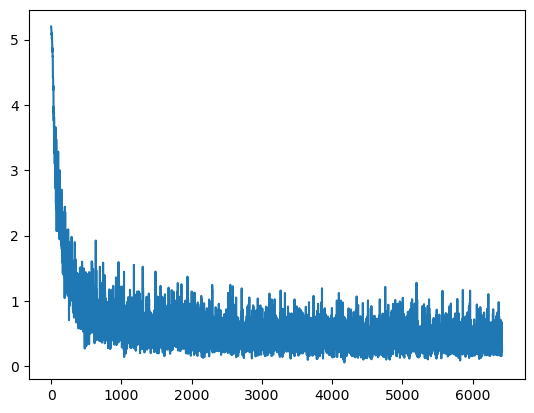

In [16]:
plt.plot(*zip(*loss_data))
plt.show()